# Advanced Lane Lines

Udacity's Self-driving Car Nanodegree Program

## 1. Camera Calibration

Using image: ./camera_cal/calibration3.jpg
Using image: ./camera_cal/calibration19.jpg
Using image: ./camera_cal/calibration8.jpg
Using image: ./camera_cal/calibration7.jpg
Using image: ./camera_cal/calibration6.jpg
Using image: ./camera_cal/calibration10.jpg
Using image: ./camera_cal/calibration2.jpg
Using image: ./camera_cal/calibration13.jpg
Using image: ./camera_cal/calibration1.jpg
Using image: ./camera_cal/calibration14.jpg
Using image: ./camera_cal/calibration17.jpg
Using image: ./camera_cal/calibration9.jpg
Using image: ./camera_cal/calibration11.jpg
Using image: ./camera_cal/calibration4.jpg
Using image: ./camera_cal/calibration16.jpg
Using image: ./camera_cal/calibration12.jpg
Using image: ./camera_cal/calibration18.jpg
Using image: ./camera_cal/calibration20.jpg
Using image: ./camera_cal/calibration5.jpg
Using image: ./camera_cal/calibration15.jpg
Done!


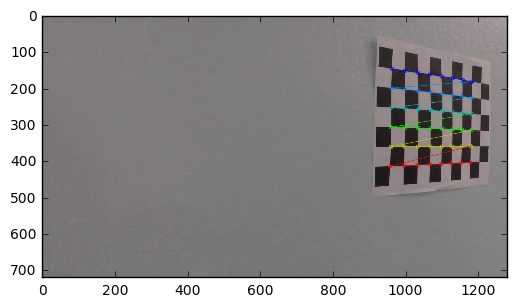

In [5]:
########################################################
# Define object points (3D) and image points (2D)
########################################################

import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

images = glob.glob('./camera_cal/calibration*.jpg')
objpoints = [] # Coordinate corners of the real chessboard object
imgpoints = [] # Coordinate corners of the image of chessboard

nx = 8 # horizontal corners
ny = 6 # vertical corners

objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)

for fname in images:
    print("Using image: " + fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Display the corners
        img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        plt.imshow(img)
        
print("Done!")

## 2. Distortion Correction

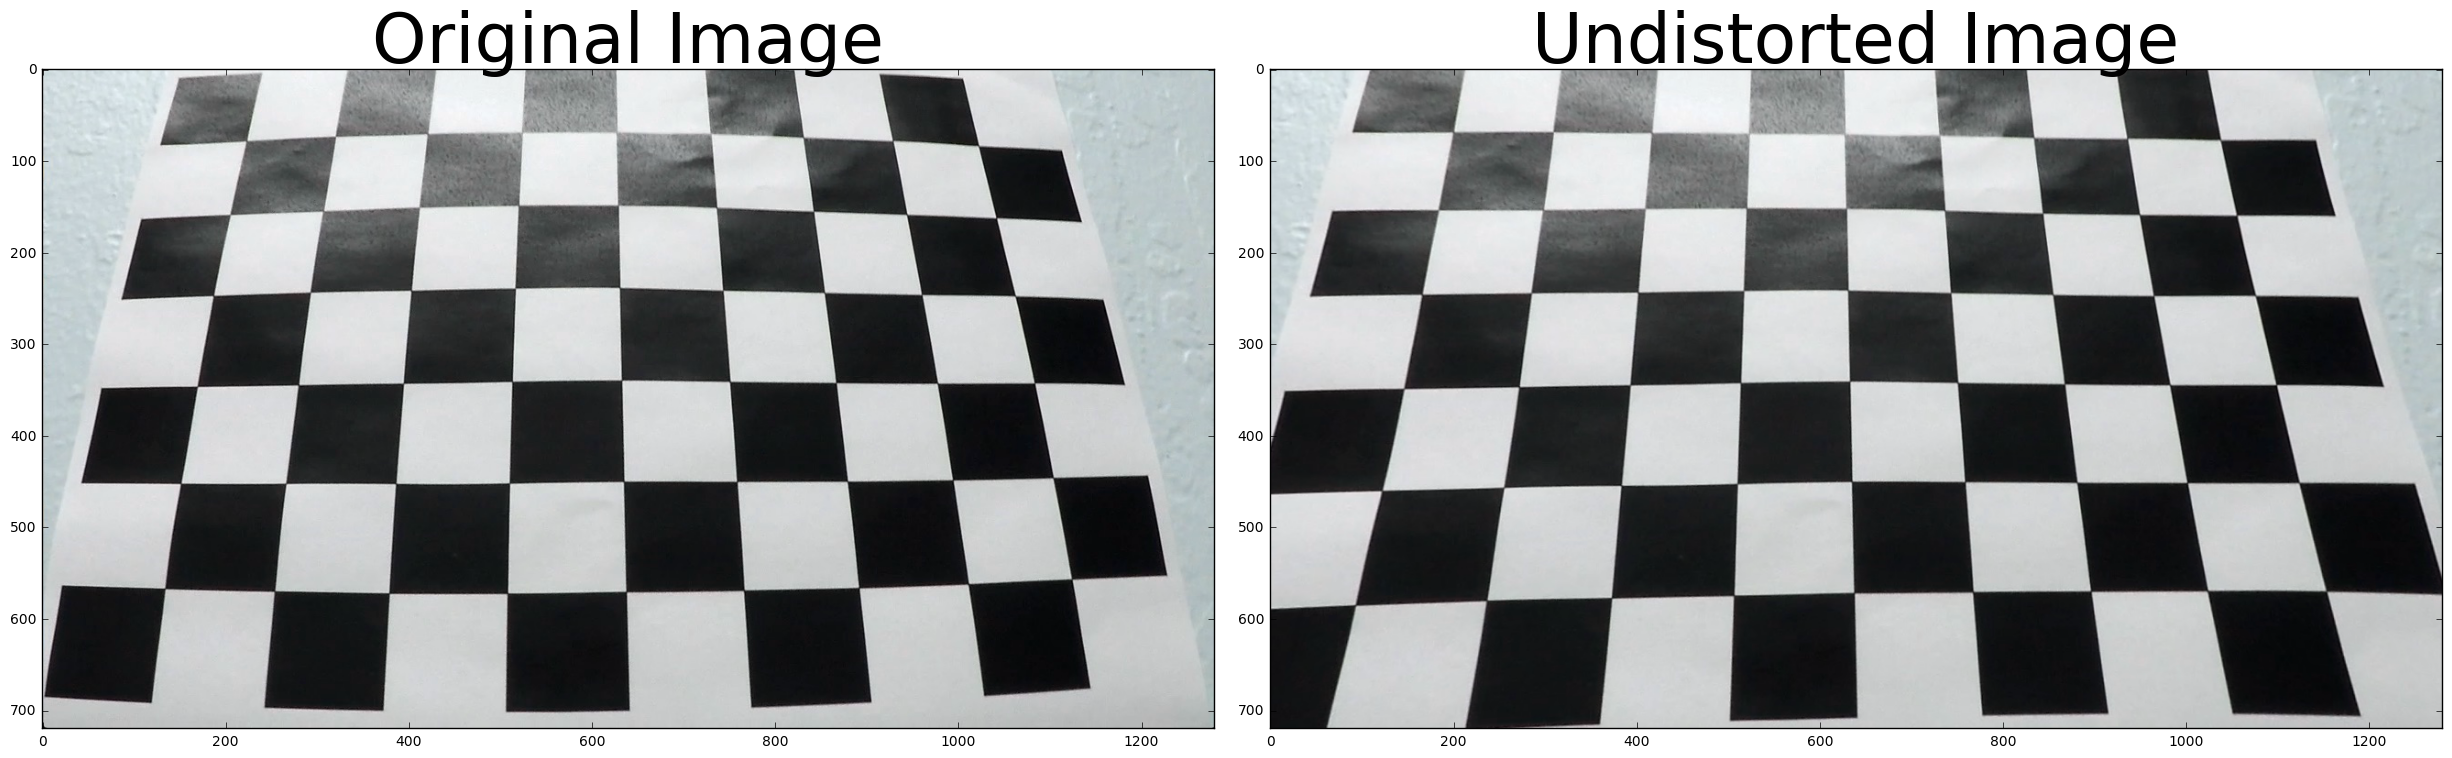

In [7]:
########################################################
# Calibrate camera with object points (3D) and image 
# points (2D)
########################################################

def calc_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread("./camera_cal/calibration3.jpg")
img_undist = calc_undistort(img, objpoints, imgpoints)

# display the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 3. Gradient Thresholding

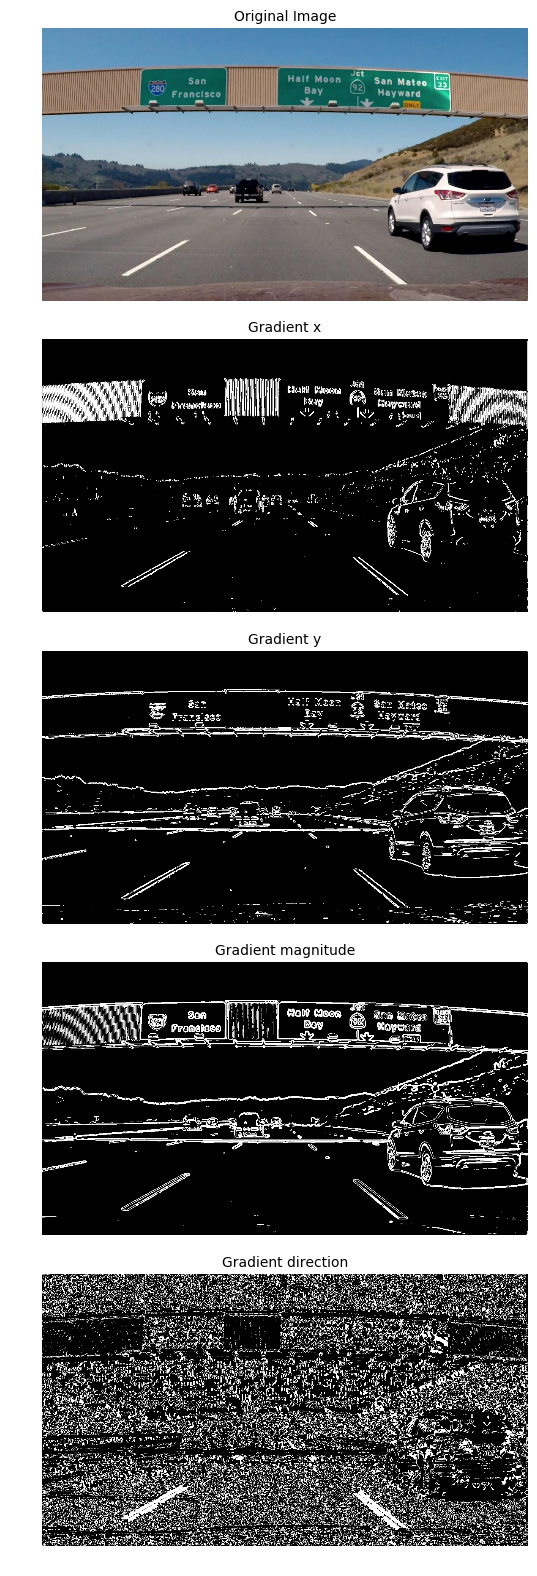

In [57]:
########################################################
# Functions to identify lane lines 
########################################################

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_g, y_g = 1, 0
    if orient ==  'y':
        x_g, y_g = 0, 1
    
    # Calculate directional gradient
    sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, x_g, y_g, ksize=sobel_kernel))
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
    
    # Apply threshold
    binary = np.zeros_like(sobel_scaled)
    binary[(sobel_scaled > thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    grad_binary = np.copy(binary)
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradient magnitude
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    abs_sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_scaled = np.uint8(255 * abs_sobel_xy / np.max(abs_sobel_xy))
    
    # Apply threshold
    binary = np.zeros_like(sobel_scaled)
    binary[(sobel_scaled > mag_thresh[0]) & (sobel_scaled <= mag_thresh[1])] = 1
    mag_binary = np.copy(binary)
   
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradient direction
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    abs_sobel_x = np.sqrt(sobel_x**2)
    abs_sobel_y = np.sqrt(sobel_y**2)
    
    gradient_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Apply threshold
    binary = np.zeros_like(abs_sobel_x)
    binary[(gradient_dir > thresh[0]) & (gradient_dir <= thresh[1])] = 1
    dir_binary = np.copy(binary)
    
    return dir_binary

image = cv2.imread("./signs_vehicles_xygrad.png")
shape = image.shape
image_ratio = shape[0] / shape[1]

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))

# display the images
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(30, 30 * image_ratio))
f.tight_layout()

ax1.axis("off")
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=10)

ax2.axis("off")
ax2.imshow(gradx, cmap="gray")
ax2.set_title('Gradient x', fontsize=10)

ax3.axis("off")
ax3.imshow(grady, cmap="gray")
ax3.set_title('Gradient y', fontsize=10)

ax4.axis("off")
ax4.imshow(mag_binary, cmap="gray")
ax4.set_title('Gradient magnitude', fontsize=10)

ax5.axis("off")
ax5.imshow(dir_binary, cmap="gray")
ax5.set_title('Gradient direction', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=1.9, bottom=1.)

## 4. Color Thresholding

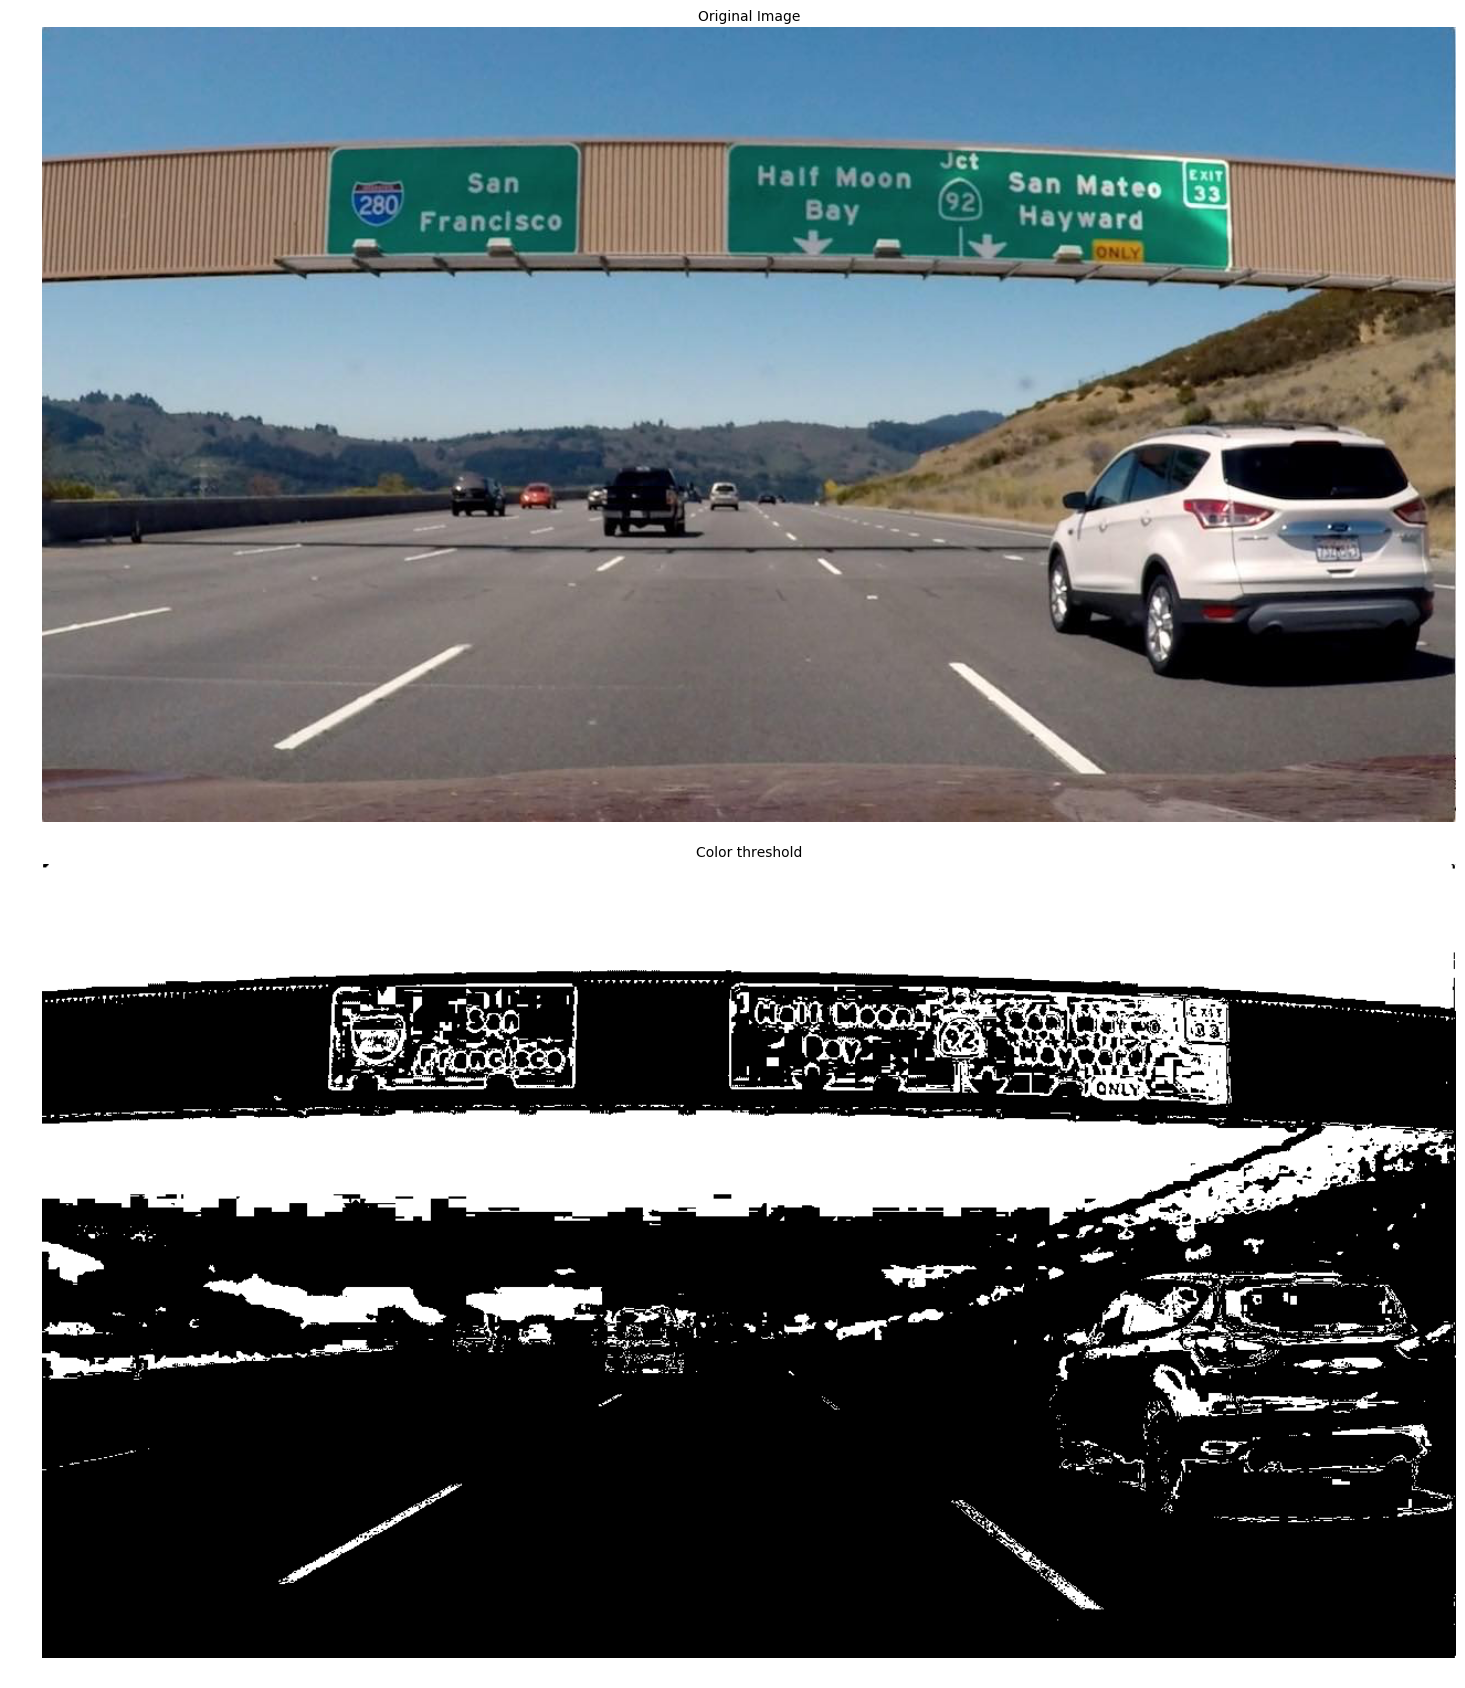

In [73]:
########################################################
# Function to identify lane lines 
########################################################
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary = np.zeros_like(s)
    binary[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    binary_output = np.copy(binary) # placeholder line
    return binary_output
    
image = cv2.imread("./signs_vehicles_xygrad.png")
shape = image.shape
image_ratio = shape[0] / shape[1]

hls_binary = hls_select(image, thresh=(80, 200))

# display the images
f, (ax1, ax2) = plt.subplots(2, figsize=(30, 30 * image_ratio))
f.tight_layout()

ax1.axis("off")
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=10)

ax2.axis("off")
ax2.imshow(hls_binary, cmap="gray")
ax2.set_title('Color threshold', fontsize=10)
